In [132]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import requests
from shapely.geometry import box
import random
import io

In [ ]:
# Leemos el fichero shapefile con la capa de las corrientes naturales de Navarra
riosGDF = gpd.read_file('files/input/HIDROG_Lin_CorrienteNatural.shp') 
# Seleccionamos las líneas correspondientes al río Ebro
rioEbroGDF = riosGDF.loc[riosGDF.NOMBRE == "Río Ebro"]
# Generamos una zona buffer de 60 metros de radio.
rioEbroGDF_buffer = rioEbroGDF.buffer(60.0)
rioEbroGDF.geometry = rioEbroGDF_buffer
# Unimos todas las zonas buffer generadas
rioEbroGDF = rioEbroGDF.dissolve(by='NOMBRE')
# Modificamos el sistema de referencia y obtenemos las coordenadas de los polígonos que forman el río ebro
rioEbroGDF = rioEbroGDF.to_crs(epsg=4326)
ebro_points = np.array([polygon.exterior.coords[:-1] for multipolygon in rioEbroGDF.geometry for polygon in multipolygon])
ebro_points = np.concatenate(ebro_points)

In [159]:
# Función para obtener un bounding box a partir de un punto central y un margen a ese punto
def get_bbox_coord(point, grow):
    lon_min = point[0] - grow
    lat_min = point[1] - grow
    lon_max = point[0] + grow
    lat_max = point[1] + grow
    return [lon_min, lat_min, lon_max, lat_max]

# Función para convertir las coordenadas geográficas a coordenadas de la imagen
def convert_latlon_pxpy(latitude, longitude, img_bbox, image):       
    coord = np.array([latitude, longitude])   
    geo_origin = np.array([img_bbox[1], img_bbox[0]])    
    geo_distance = [img_bbox[2] - img_bbox[0], img_bbox[3] - img_bbox[1]]
    img_distance = [image.width, image.height]
    pxpy = np.flip((np.subtract(coord, geo_origin) * img_distance)/geo_distance)
    return tuple(np.subtract(np.array([2 * pxpy[0], 256]), pxpy))

In [139]:
url = """https://idena.navarra.es/ogc/wms"""
parameters = {
    'service': 'WMS',
    'version': '2.0.0',
    'LAYERS': 'IDENA:ortofoto_maxima_actualidad',
    'CRS': 'EPSG:4326',
    'request': 'getMap',
    'format': 'image/png',
    'BBOX': '{lon_min,lat_min,lon_max,lat_max}',
    'WIDTH': '256',
    'HEIGHT': '256'
}

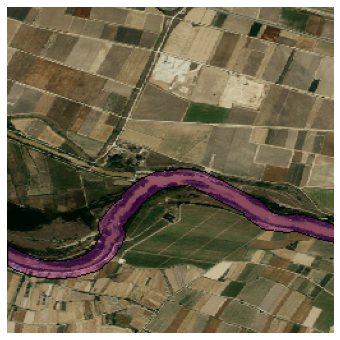

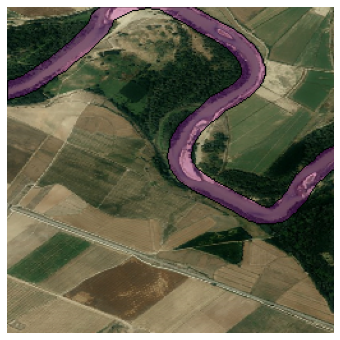

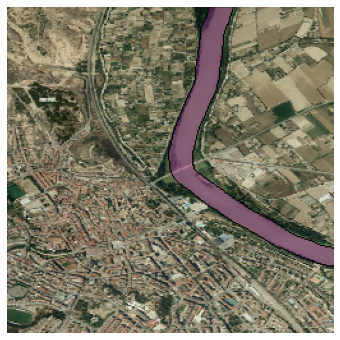

In [177]:
img_grow = 0.01

for i, point in enumerate(random.choices(ebro_points, k=3)):
    try:
        # Generar bounding box a partir de un punto del río ebro y un margen (img_grow) 
        img_bbox_coord = get_bbox_coord(point, img_grow)

        # Descarga de la imágen del servicio WMS de IDENA
        parameters['BBOX'] = ",".join(str(coord) for coord in img_bbox_coord)
        response = requests.get(url, params=parameters, stream=True)
        img = Image.open(io.BytesIO(response.content))

        # Generar intersección entre el bbox y la capa obtenida en 
        lon_min, lat_min, lon_max, lat_max = img_bbox_coord
        img_bbox = gpd.GeoSeries([Polygon([(lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min), (lon_min, lat_min)])])
        img_bbox_gdf = gpd.GeoDataFrame({'geometry': img_bbox})
        img_bbox_gdf = img_bbox_gdf.set_crs(epsg = 4326)
        intersectionGDF = rioEbroGDF.overlay(img_bbox_gdf, how='intersection') 
        
        draw = ImageDraw.Draw(img, 'RGBA')
        poly_coords = intersectionGDF.geometry[0].exterior.coords[:-1]
        river_coord = [convert_latlon_pxpy(poly_coord[1], poly_coord[0], img_bbox_coord, img) for poly_coord in poly_coords]
        draw.polygon(river_coord, fill=(255, 0, 255, 50), outline=(0,0,0,255))

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')
    except Exception as err:
        print(err)
        continue